
## Capstone project- The Battle of Neighbourhoods

### Table of Contents
1.  [Introduction](#1)<br>
2.  [Data sources](#2)<br>
3.  [Methodology](#3) <br>
4.  [Results](#4) <br>
5.  [Discussion](#5) <br>
6.  [Conclusion](#6) <br> 
7.  [Acknowledgement](#7) <br> 

### Introduction<a class="anchor" id="#1"></a>
Suppose that a person of South Asian origin wishes to immigrate to Toronto, Canada. Being from a different culture, expectations and baseline requirements for lifestyle differ widely from those in Toronto. Three questions occur to the immigrant's mind:
1. What would be the "new normal", the anticipated new baselines for living in Toronto?
2. If they were to get a job in Toronto, which neighbourhoods should they prefer to stay in?
3. What are some correlations in the data they should be aware of?

How would a person evaluate these questions? Fortunately, there is a plenty of data made available by the following sources:

### Data sources<a class="anchor" id="#2"></a>
We will address the sources for data pertaining to each question:

1. **Foursquare** for Toronto Venues data- This was used to inform the venues in each Toronto neighbourhood.
2. **Wellbeing Toronto**'s NHS Demographics Indicators, 2010.
3. **Wellbeing Toronto**'s 2011 data from the **Open Data Catalogue, City of Toronto** for the following data:
* Economic data- No. of Businesses, Home Prices (CAD), Social Assistance Recipients (nos.),
* Traffic data- Road Volume (nos.) 
* Environment data- Tree Cover
* Safety data- Total Major Crimes, Vehicle Thefts (nos.)
* Demographics data- Population, Total Visible Minority, S.Asian, Recently Moved S.Asians, No. in Labour Force, Unemployed, Renters, Major repairs needed, (All in nos.), shelter30 (% of owner households spending 30% or more of household total income on shelter costs), Avg. Monthly Rent (CAD), Median After-tax Income (CAD)
4. **Toronto GeoJSON** from [https://github.com/jasonicarter/toronto-geojson ], to help generate the Toronto choropleth maps.

The appropriate links to data are referenced in the code when they are required.

### Methodology<a class="anchor" id="#3"></a>

#### Step-1: Preparation of the base DataFrame
The base DataFrame is expected to contain Toronto neighbourhoods, geo-spatial, economic, housing and road volume data. We will progressively build this DataFrame by reading the referenced data sources.

##### Mandatory imports

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # To suppress warning
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import re # For regex on the JSON file

#!conda install -c conda-forge geopy --yes # comment if installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # To import and modify Toronto json
import urllib.request # To import and modify Toronto json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from math import isnan

#!conda install -c conda-forge folium=0.5.0 --yes # comment if installed
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


##### Obtaining data from referenced Data sources
The following data was sourced from **Wellbeing Toronto**'s 2011 data from the **Open Data Catalogue, City of Toronto**.

In [2]:
# Reading "Wellbeing Toronto - Economics" 2011 data- https://open.toronto.ca/dataset/wellbeing-toronto-economics/
df_econ = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/78cf2678-8cd9-442b-a8e7-ed9ae6e82e01',sheet_name=2)
new_header = df_econ.iloc[0] #grab the first row for the header
df_econ = df_econ[1:] #take the data less the header row
df_econ.columns = new_header #set the header row as the df header
df_econ[['Businesses','Home Prices','Social Assistance Recipients']] = df_econ[['Businesses','Home Prices','Social Assistance Recipients']].astype(str).astype(int)
df = df_econ[['Neighbourhood Id','Neighbourhood','Businesses','Home Prices','Social Assistance Recipients']]
df.rename(columns={"Neighbourhood Id": "ID"},inplace=True)

In [3]:
# Locating neighbourhoods using Geopy
df_geo = pd.DataFrame(columns=['Neighbourhood', 'Latitude','Longitude'])
count_fail = 0
for location_name in df_econ['Neighbourhood']:
    address = str(location_name)+', Toronto, Canada'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
        df_geo = df_geo.append({'Neighbourhood':location_name,'Latitude':latitude,'Longitude':longitude},ignore_index = True)
    except:
        count_fail+=1
        continue
print(str(count_fail)+' neighbourhoods could not be located.')

36 neighbourhoods could not be located.


In [4]:
# Reading "Wellbeing Toronto - Transportation" 2011 data- https://open.toronto.ca/dataset/wellbeing-toronto-transportation/
df_tran = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/70a22fc6-e3c5-4b05-b26e-16c2a6577eb4',sheet_name=2)
df_tran = df_tran[['Neighbourhood Id','Road Volume']]
# Reading "Wellbeing Toronto - Environment" 2011 data- https://open.toronto.ca/dataset/wellbeing-toronto-environment/
df_tree = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/87cb3a08-0929-4c60-bd87-1dac04e41689',sheet_name=2)
df_tree = df_tree[['Neighbourhood Id','Tree Cover']]
# Reading "Wellbeing Toronto - Safety" 2011 data- https://open.toronto.ca/dataset/wellbeing-toronto-safety/
df_crime = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/29a9f70b-0273-49a5-b770-4def7c2a063f',sheet_name=2)
new_header = df_crime.iloc[0] #grab the first row for the header
df_crime = df_crime[1:] #take the data less the header row
df_crime.columns = new_header #set the header row as the df header
df_crime = df_crime[['Neighbourhood Id','Total Major Crime Incidents','Vehicle Thefts']]
df_crime[['Total Major Crime Incidents','Vehicle Thefts']]=df_crime[['Total Major Crime Incidents','Vehicle Thefts']].astype(str).astype(int)
df_crime.rename(columns={"Total Major Crime Incidents": "Crime"},inplace=True)
# Reading "Wellbeing Toronto - Demographics: NHS Indicators" 2011 data- https://open.toronto.ca/dataset/wellbeing-toronto-demographics-nhs-indicators/
df_dem = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/8d838d5c-20da-48bd-b4a7-3e66b1c25b55')
new_header = df_dem.iloc[0] #grab the first row for the header
df_dem = df_dem[1:] #take the data less the header row
df_dem.columns = new_header #set the header row as the df header
df_dem=df_dem[['ID','popt01','vismin04','recbirth1','recbirth76','plf15_2','plf15_4','occprdw06','occprdw11','shelter30','occprdw21','incprhh58']]
df_dem.rename(columns={"popt01": "Population","vismin04":"Total Visible Minority","recbirth1":"S.Asian","recbirth76":"Recently Moved S.Asians","plf15_2":"Labour Force","plf15_4":"Unemployed","occprdw06":"Renters","occprdw11":"Major repairs needed","occprdw21":"Avg. Monthly Rent","incprhh58":"Median After-tax Income"},inplace=True)
df_dem[['ID','Population','Total Visible Minority','S.Asian','Recently Moved S.Asians','Labour Force','Unemployed','Renters','Major repairs needed']]=df_dem[['ID','Population','Total Visible Minority','S.Asian','Recently Moved S.Asians','Labour Force','Unemployed','Renters','Major repairs needed']].astype(str).astype(int)
df_dem[['shelter30','Avg. Monthly Rent','Median After-tax Income']]=df_dem[['shelter30','Avg. Monthly Rent','Median After-tax Income']].astype(str).astype(float)

In [5]:
# Join all the dataframes
df = df.join(df_geo.set_index('Neighbourhood'), on='Neighbourhood')
df = df.join(df_tran.set_index('Neighbourhood Id'), on='ID')
df = df.join(df_tree.set_index('Neighbourhood Id'), on='ID')
df = df.join(df_crime.set_index('Neighbourhood Id'), on='ID')
df = df.join(df_dem.set_index('ID'), on='ID')
df.at[93,'Neighbourhood']= 'Dovercourt-Wallace Emerson-Junction' # Rectifying this entry
df.head()

,ID,Neighbourhood,Businesses,Home Prices,Social Assistance Recipients,Latitude,Longitude,Road Volume,Tree Cover,Crime,Vehicle Thefts,Population,Total Visible Minority,S.Asian,Recently Moved S.Asians,Labour Force,Unemployed,Renters,Major repairs needed,shelter30,Avg. Monthly Rent,Median After-tax Income
1,1,West Humber-Clairville,2463,317508,2912,43.723370,-79.597457,5956.638889,2.895861e+06,1119,288,34100,13080,2750,1495,17610,1750,3050,415,27.9,945.0,59703.0
2,2,Mount Olive-Silverstone-Jamestown,271,251119,6561,NaN,NaN,3514.166667,1.303945e+06,690,62,32790,12720,5850,2625,14655,2175,5070,1100,33.3,921.0,46986.0
3,3,Thistletown-Beaumond Heights,217,414216,1276,NaN,NaN,3545.000000,1.499130e+06,192,12,10140,2285,1070,400,4825,530,1145,170,25.1,887.0,57522.0
4,4,Rexdale-Kipling,144,392271,1323,43.722114,-79.572292,7621.333333,7.563823e+05,164,18,10485,1435,800,405,5270,590,1935,340,19.7,857.0,51194.0
5,5,Elms-Old Rexdale,67,233832,1683,43.721770,-79.552173,4115.500000,9.975108e+05,185,22,9550,925,545,80,4640,575,1315,320,34.3,966.0,49425.0


The dataframe is now ready. There were some neighbourhoods that could not be matched using Geopy's geolocator. Unfortunately, they will be skipped during obtaining Venue data. This will not affect non-Venue based data analysis carried out on those neighbourhoods.

#### Step-2: Utilizing FourSquare API to extend base DataFrame to include Venues data
##### Setting FourSquare credentials

In [6]:
CLIENT_ID = '<SECRET>' # your Foursquare ID
CLIENT_SECRET = '<SECRET>' # your Foursquare Secret
VERSION = '<secret>' # Foursquare API version, aka current date
LIMIT = 100 # A default Foursquare API limit value

##### Obtaining venues in specific neighbourhoods

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

These are obtained into a new DataFrame, as follows:

In [8]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

The unique venues are given below and this will be used to inform venues of interest:

In [9]:
toronto_venues['Venue Category'].unique()

array(['Grocery Store', 'Chinese Restaurant', 'Food & Drink Shop',
       'Department Store', 'Bank', 'Sporting Goods Shop',
       'Sandwich Place', 'Coffee Shop', 'Theme Park', 'Bus Station',
       'Discount Store', 'Mobile Phone Shop', 'Fast Food Restaurant',
       'Pizza Place', 'Pool', 'Hakka Restaurant', 'African Restaurant',
       'Caribbean Restaurant', 'Bar', 'Diner', 'Skating Rink', 'Pharmacy',
       'Gas Station', 'Fried Chicken Joint', 'Soccer Field', 'Café',
       'Gift Shop', 'Indian Restaurant', 'Park', 'Bus Stop',
       'Golf Course', 'Piano Bar', 'Baseball Field',
       'Arts & Crafts Store', 'Pool Hall', 'Burger Joint',
       'Portuguese Restaurant', 'Restaurant', 'Miscellaneous Shop',
       'Pet Store', 'Furniture / Home Store', 'Baby Store', 'Bakery',
       'Beer Store', 'Thai Restaurant', 'Japanese Restaurant',
       'Sushi Restaurant', 'Pub', 'Gym', 'Metro Station',
       'Italian Restaurant', 'Seafood Restaurant', 'Tapas Restaurant',
       'Dessert S

Based on the list above, Indian/Pakistani restaurants are selected as sample venues of interest to a South Asian. This selection can be reworked on a case-basis for specific customers.

##### One-Hot Encoding to obtain no. of venues at each location:

In [10]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [11]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()

At the end of this step, we have the dataframe of venues around neighborhoods, grouped by neighborhood. We define the following function to obtain the count of South Asian food venues for the neighborhoods.

In [12]:
# Return the number of South Asian restaurants in the neighbourhood
def return_count_south_asian(row):
    row_categories = row.iloc[1:]
    row_categories = row_categories[row_categories!=0]
    row_south_asian = row_categories.keys()
    val = [i for i in row_south_asian if 'India' in i or 'Pakistan' in i]
    return len(val)

In [13]:
columns = ['Neighbourhood','S. Asian Rest. count']
# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1] = return_count_south_asian(toronto_grouped.iloc[ind, :])

In [14]:
#Join into baseline database
df_venues = df.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

With this, the neighbourhoods_venues_sorted dataframe contains venue-related information for neighbourhoods.

In [15]:
df_venues['S. Asian Rest. count'] = df_venues['S. Asian Rest. count'].fillna(0)
df_venues.head()

,ID,Neighbourhood,Businesses,Home Prices,Social Assistance Recipients,Latitude,Longitude,Road Volume,Tree Cover,Crime,Vehicle Thefts,Population,Total Visible Minority,S.Asian,Recently Moved S.Asians,Labour Force,Unemployed,Renters,Major repairs needed,shelter30,Avg. Monthly Rent,Median After-tax Income,S. Asian Rest. count
1,1,West Humber-Clairville,2463,317508,2912,43.723370,-79.597457,5956.638889,2.895861e+06,1119,288,34100,13080,2750,1495,17610,1750,3050,415,27.9,945.0,59703.0,0
2,2,Mount Olive-Silverstone-Jamestown,271,251119,6561,NaN,NaN,3514.166667,1.303945e+06,690,62,32790,12720,5850,2625,14655,2175,5070,1100,33.3,921.0,46986.0,0
3,3,Thistletown-Beaumond Heights,217,414216,1276,NaN,NaN,3545.000000,1.499130e+06,192,12,10140,2285,1070,400,4825,530,1145,170,25.1,887.0,57522.0,0
4,4,Rexdale-Kipling,144,392271,1323,43.722114,-79.572292,7621.333333,7.563823e+05,164,18,10485,1435,800,405,5270,590,1935,340,19.7,857.0,51194.0,0
5,5,Elms-Old Rexdale,67,233832,1683,43.721770,-79.552173,4115.500000,9.975108e+05,185,22,9550,925,545,80,4640,575,1315,320,34.3,966.0,49425.0,0


With this, our database of neighbourhoods is loaded with venue data, based on a filter chosen as applicable for South Asians. It is ready to be clustered upon, but before that, we conduct a preliminary exploratory data analysis.

#### Step-3: Exploratory data analyses, inferential statistics

##### The describe() function provides the descriptive statistics:

In [6]:
df.describe()

,Businesses,Home Prices,Social Assistance Recipients,Latitude,Longitude,Road Volume,Tree Cover,Crime,Vehicle Thefts,Population,Total Visible Minority,S.Asian,Recently Moved S.Asians,Labour Force,Unemployed,Renters,Major repairs needed,shelter30,Avg. Monthly Rent,Median After-tax Income
count,140.000000,1.400000e+02,140.000000,104.000000,104.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,536.321429,5.481934e+05,1864.700000,43.707452,-79.387368,4372.328555,1.281438e+06,351.128571,29.821429,18676.928571,2264.928571,1546.785714,327.035714,9999.928571,934.464286,3400.678571,586.928571,27.282857,1019.792857,55426.500000
std,637.210719,2.676674e+05,1504.562647,0.054008,0.102183,2033.085003,1.343461e+06,235.957009,34.029033,9099.209342,3394.624506,1290.023572,565.754064,5066.518677,531.797785,2396.058605,303.447568,6.735805,219.621994,16118.155356
min,47.000000,2.041040e+05,37.000000,43.592005,-79.597457,0.000000,6.161624e+04,81.000000,3.000000,6490.000000,90.000000,130.000000,0.000000,3150.000000,215.000000,200.000000,95.000000,13.500000,631.000000,30794.000000
25%,169.750000,3.749645e+05,697.000000,43.667710,-79.445072,3266.650000,5.231621e+05,185.000000,13.000000,11851.250000,445.000000,531.250000,13.750000,6597.500000,565.000000,1808.750000,368.750000,22.475000,878.500000,46689.500000
50%,345.500000,4.912100e+05,1455.000000,43.698874,-79.396078,4162.388889,1.017744e+06,294.000000,21.000000,16367.500000,970.000000,1180.000000,95.000000,8602.500000,795.000000,2975.000000,530.000000,27.200000,972.500000,52660.000000
75%,591.000000,5.902160e+05,2682.750000,43.753015,-79.315708,5557.000000,1.686216e+06,412.500000,35.000000,22410.000000,2668.750000,2156.250000,406.250000,12140.000000,1240.000000,4166.250000,782.500000,31.925000,1124.750000,59963.000000
max,4324.000000,1.849084e+06,7263.000000,43.823174,-79.150768,13491.500000,1.288804e+07,1393.000000,288.000000,53350.000000,20985.000000,6650.000000,4060.000000,33045.000000,3310.000000,13640.000000,1640.000000,48.800000,2388.000000,161448.000000


The pair-wise correlation and the below pairplot give us a clearer picture of the interrelationships between these parameters.

In [7]:
# Pair-wise correlation among the columns
df.corr('kendall')

,Businesses,Home Prices,Social Assistance Recipients,Latitude,Longitude,Road Volume,Tree Cover,Crime,Vehicle Thefts,Population,Total Visible Minority,S.Asian,Recently Moved S.Asians,Labour Force,Unemployed,Renters,Major repairs needed,shelter30,Avg. Monthly Rent,Median After-tax Income
Businesses,1.000000,-0.039276,0.192964,-0.033087,0.016263,0.114935,0.047090,0.468252,0.401266,0.439165,0.190280,0.300860,0.210590,0.474623,0.369974,0.357661,0.246689,0.197950,0.107321,-0.048118
Home Prices,-0.039276,1.000000,-0.544314,-0.172614,-0.113581,0.008948,0.054265,-0.296472,-0.266120,-0.193071,-0.506999,-0.338186,-0.423551,-0.116474,-0.351706,-0.117115,-0.201454,-0.370089,0.353921,0.414594
Social Assistance Recipients,0.192964,-0.544314,1.000000,0.127652,0.120923,-0.000103,0.022209,0.566224,0.405525,0.431760,0.535420,0.507128,0.506753,0.352034,0.572826,0.424112,0.504408,0.362616,-0.376498,-0.498252
Latitude,-0.033087,-0.172614,0.127652,1.000000,0.361495,0.015707,0.333645,-0.009537,0.115719,0.215701,0.341692,0.295812,0.317790,0.133607,0.246119,-0.088955,-0.078891,0.109915,-0.006543,0.026527
Longitude,0.016263,-0.113581,0.120923,0.361495,1.000000,-0.223261,0.090043,0.107901,-0.034659,0.203364,0.328967,0.164174,0.283143,0.175091,0.240509,0.028406,0.123115,0.040633,-0.083559,0.011582
Road Volume,0.114935,0.008948,-0.000103,0.015707,-0.223261,1.000000,0.113243,0.004633,0.121265,0.077885,-0.057578,0.078357,-0.026095,0.081276,0.050062,0.071414,-0.064969,0.038965,0.199074,0.039187
Tree Cover,0.047090,0.054265,0.022209,0.333645,0.090043,0.113243,1.000000,0.016459,0.222926,0.286214,0.162619,0.171511,0.173618,0.248060,0.184757,-0.025808,-0.012675,-0.170058,0.155001,0.302980
Crime,0.468252,-0.296472,0.566224,-0.009537,0.107901,0.004633,0.016459,1.000000,0.495007,0.527269,0.387761,0.424592,0.380021,0.501209,0.574564,0.488550,0.479398,0.288572,-0.188706,-0.307170
Vehicle Thefts,0.401266,-0.266120,0.405525,0.115719,-0.034659,0.121265,0.222926,0.495007,1.000000,0.511527,0.360815,0.417126,0.333351,0.451783,0.500175,0.250973,0.243813,0.175032,-0.045513,-0.117849
Population,0.439165,-0.193071,0.431760,0.215701,0.203364,0.077885,0.286214,0.527269,0.511527,1.000000,0.440853,0.598055,0.429937,0.853411,0.755831,0.482283,0.464981,0.214827,0.031174,-0.093760


##### The pairwise plot allows for quick comparison between all variables in our dataframe:

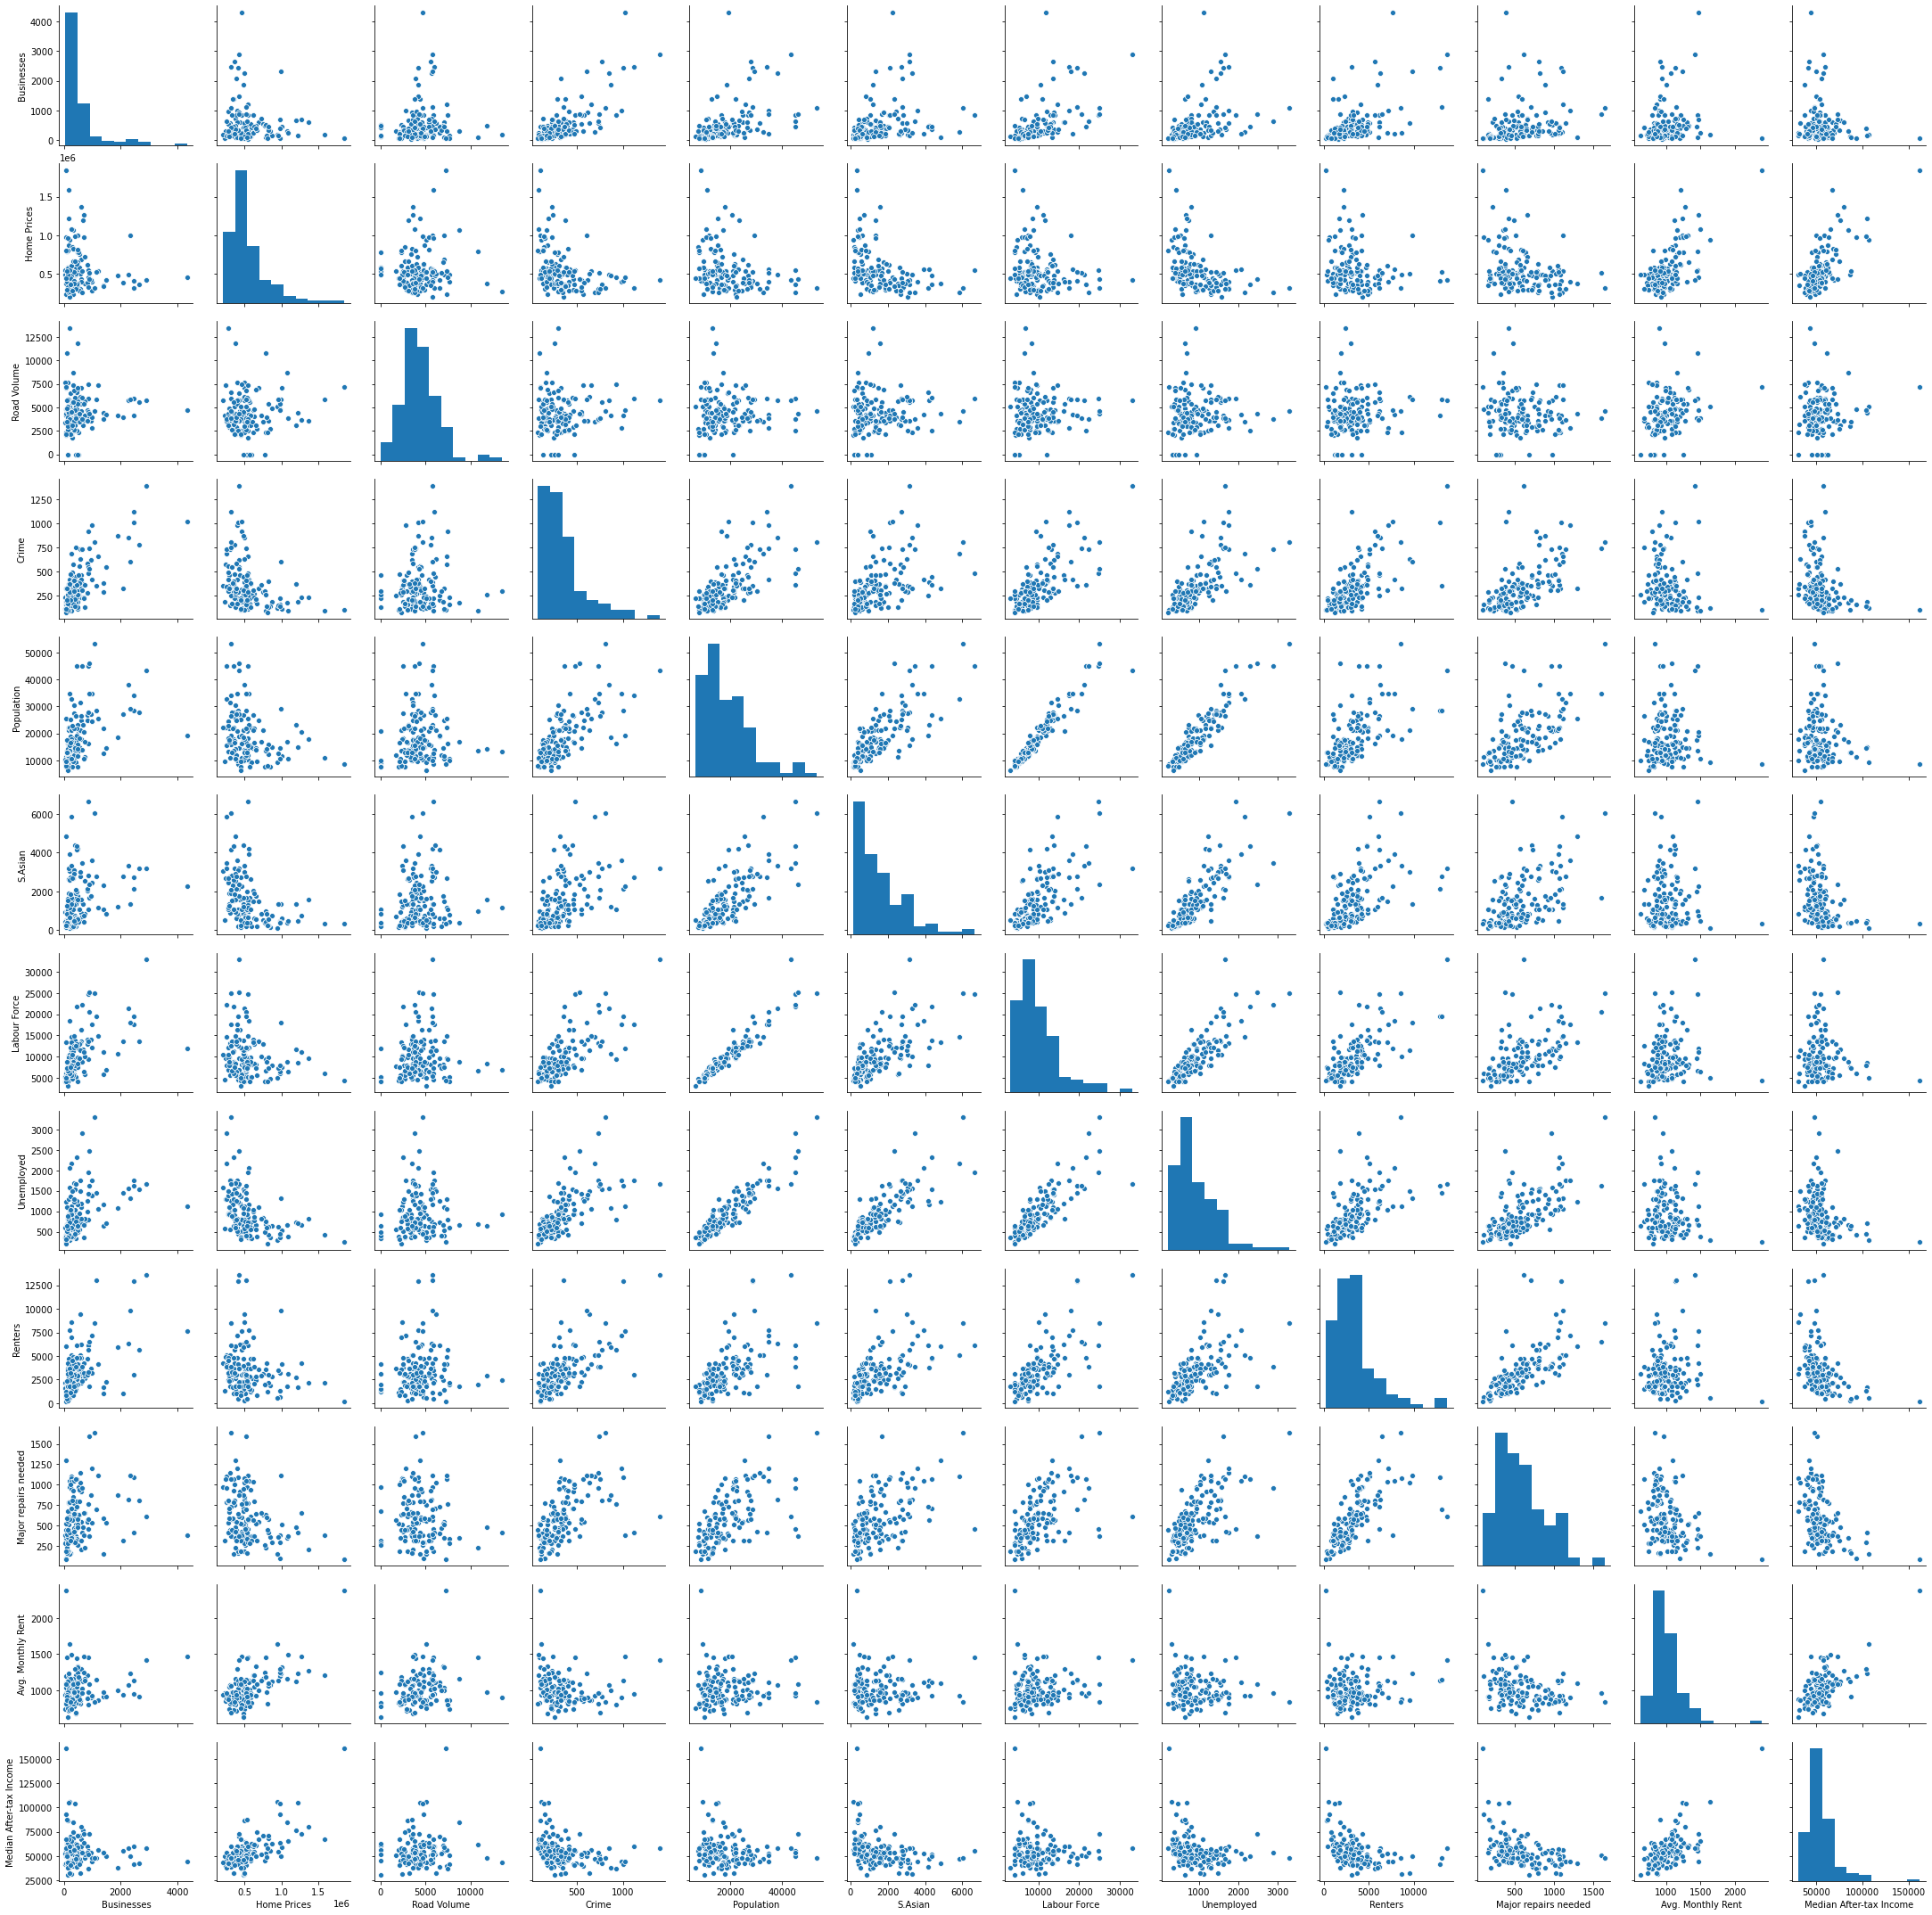

In [10]:
df_eda = df.drop(['ID', 'Latitude','Longitude','Neighbourhood','Tree Cover','Vehicle Thefts','Total Visible Minority','Recently Moved S.Asians','Social Assistance Recipients','shelter30'], axis=1)
sns.pairplot(df_eda, kind="scatter") #Unused parameters-> hue="S.Asian",diag_kws={'bw': 0.25}) | plot_kws={'line_kws':{'color':'red'}}

#### Step-4: Clustering

In the clustering activity, we use the dataframe with venue details created. We select the neighbourhoods significant to our optimization routine, one-hot encode them and obtain a choropleth map of neighbourhoods.

In [16]:
# df_venues.columns
# Selected columns - Crime, S.Asian, Avg. Monthly Rent, S. Asian Rest. count, shelter30

# Set up dataframe for clustering
df_clustering = df_venues[['Crime', 'S.Asian', 'Avg. Monthly Rent', 'S. Asian Rest. count', 'shelter30']]

# Scaling
from sklearn.preprocessing import StandardScaler
X = df_clustering.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

In [17]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(init="k-means++",n_clusters=kclusters, n_init=12,random_state=0).fit(cluster_dataset)

In [23]:
# add clustering labels on df_venues with Venues data
df_venues = df_venues.reset_index(drop=True)
try: 
    df_venues.insert(0, 'Cluster Labels', kmeans.labels_)
    print('Cluster label inserted.')
except:
    print('Cluster label already inserted.')

Cluster label already inserted.


In [53]:
# Examination of clusters
for i in df_venues['Cluster Labels'].unique():
    print('Cluster No. {} (Count= {})'.format(i,len(df_venues[df_venues['Cluster Labels'] == i])))
    print('Crime : {}'.format(df_venues[df_venues['Cluster Labels'] == i]['Crime'].mean()))
    print('S. Asians : {}'.format(df_venues[df_venues['Cluster Labels'] == i]['S.Asian'].mean()))
    print('Avg. Monthly Rent : {}'.format(df_venues[df_venues['Cluster Labels'] == i]['Avg. Monthly Rent'].mean()))
    print('Venue Count : {}'.format(df_venues[df_venues['Cluster Labels'] == i]['S. Asian Rest. count'].mean()))
    print('Shelter30 : {}'.format(df_venues[df_venues['Cluster Labels'] == i]['shelter30'].mean()))
    print('----------------------------------------------')

Cluster No. 3 (Count= 61)
Crime : 358.1311475409836
S. Asians : 1231.72131147541
Avg. Monthly Rent : 920.5737704918033
Venue Count : 0.0
Shelter30 : 28.34426229508197
----------------------------------------------
Cluster No. 2 (Count= 24)
Crime : 521.5416666666666
S. Asians : 3654.5833333333335
Avg. Monthly Rent : 1081.9583333333333
Venue Count : 0.125
Shelter30 : 34.083333333333336
----------------------------------------------
Cluster No. 1 (Count= 29)
Crime : 195.27586206896552
S. Asians : 702.5862068965517
Avg. Monthly Rent : 1196.0689655172414
Venue Count : 0.034482758620689655
Shelter30 : 19.95862068965517
----------------------------------------------
Cluster No. 0 (Count= 26)
Crime : 351.2307692307692
S. Asians : 1281.923076923077
Avg. Monthly Rent : 998.5769230769231
Venue Count : 1.0384615384615385
Shelter30 : 26.684615384615384
----------------------------------------------


The numbers of neighbourhoods in each cluster is comparable. Because the clustering was done on the above-selected parameters, cluster elements will be similar to each other rather than different. Thus, the statistics above enables comparison between clusters:
* Cluster 3 is least favourable with 0 mean Venues.
* Cluster 2 is less favourable than 0 or 1 due to higher Crime.
* With both overall lesser Rent and higher S. Asians to amalgamate into the community, Cluster 0 is chosen the most favourable. 

This prompts a convenient ordering: 0 > 1 > 2 > 3

*Note:* It is true that both Crime and Shelter30 are higher for Cluster 0. This prompts a certain level of caution to be maintained in living in these areas.

#### Step-5: Mapping the clusters

In [54]:
# Creating a single function for creating maps
def create_toronto_map(df,column_name):
    # Accessing Toronto JSON data from the source
    tor_geo = r'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson'
    
    # create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum value
    threshold_scale = np.linspace(df[column_name].min(),
                                  df[column_name].max(),
                                  6, dtype=int)
    threshold_scale = threshold_scale.tolist() # change the numpy array to a list
    threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum value
    
    # Setting up the map to zoom into Toronto
    address = 'Toronto, Canada'
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
    
    toronto_map.choropleth(
        geo_data=tor_geo,
        data=df,
        columns=['Map_ID', column_name],
        key_on='feature.properties.AREA_NAME',
        threshold_scale=threshold_scale,
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name=str(column_name)+' in Toronto',
        reset=True
    )
    return toronto_map

In [74]:
#Add a column Map_ID to enable compatibility with the GeoJSON
# Note that this is also data cleaning
df_venues['Map_ID'] = df_venues.apply (lambda row: str(row['Neighbourhood'])+' ('+str(row['ID'])+')', axis=1)
df_venues.at[16,'Map_ID']= 'Mimico (includes Humber Bay Shores) (17)'
df_venues.at[58,'Map_ID']= 'Danforth East York (59)'

We create the below function to map the neighbourhoods on a choropleth map for different data.

In [76]:
create_toronto_map(df_venues,'Cluster Labels')

# Note: Other data may be mapped on Toronto but these are left to the user.
#create_toronto_map(df,'Avg. Monthly Rent')
#create_toronto_map(df,'Crime')
#create_toronto_map(df,'Vehicle Thefts')
#create_toronto_map(df,'S.Asian')

In the map generated, the lighter-shaded areas are those to be preferred by a South Asian immigrant, with progressively darker-shaded areas indicating unfavourability, as  based on the clustering above.

### Results <a class="anchor" id="#4"></a>

Three questions were posed at the Introduction as follows: 

1. **What would be the "new normal", the anticipated new baselines for living in Toronto?** The descriptive statistics on some basic neighbourhood parameters (including **Population, Income, Avg. Rent**) were conducted, and some of these are reproduced in the table below. The pairwise plots (above) show in great visual detail the density of points around the mean values, and enhance our idea of expected values for these.

2. **If they were to get a job in Toronto, which neighbourhoods should they prefer to stay in?** A choropleth map of Toronto neighbourhoods above was generated, with more favourable areas showing in lighter colour. 

3. **What are some correlations in the data they should be aware of?** From studying the pairwise plot and pairwise correlations, some correlations are listed as below:
* Home prices and neighbourhood population are negatively correlated. Living in less-crowded areas comes with a premium!
* Broad positive correlation between Neighbourhood population, Crime, 'Major repairs needed' with inverse correlation to median household income.
* As far as living in neighbourhoods goes, Higher the income, higher the rent.

In [82]:
df[['Population','Median After-tax Income','Avg. Monthly Rent','Home Prices']].describe()

,Population,Median After-tax Income,Avg. Monthly Rent,Home Prices
count,140.000000,140.000000,140.000000,1.400000e+02
mean,18676.928571,55426.500000,1019.792857,5.481934e+05
std,9099.209342,16118.155356,219.621994,2.676674e+05
min,6490.000000,30794.000000,631.000000,2.041040e+05
25%,11851.250000,46689.500000,878.500000,3.749645e+05
50%,16367.500000,52660.000000,972.500000,4.912100e+05
75%,22410.000000,59963.000000,1124.750000,5.902160e+05
max,53350.000000,161448.000000,2388.000000,1.849084e+06


### Discussion <a class="anchor" id="#5"></a>

A data science project is as good as the data sources and methodology of analysis that generate it. The following are the key areas of potential gaps in this study:
* Geolocator data for which Lat-Long pairs are not mapped could not be used to generate Venues data from Foursquare. In this study, we considered 5 parameters important to a South Asian immigrant- No. of South Asians in a neighbourhood, Crime, Avg. Monthly Rent, Shelter30, and No. of Venues. Therefore, some neighbourhoods would be preferentially clustered into a less favourable cluster. This can be fixed by manually fixing Lat-Long co-ordinates, but is not done in the present study.
* The 5 parameters chosen were Crime, S. Asians count, Avg. Monthly rent, Venue count, Shelter30 may be varied on a need-basis with further model-tuning.
* From exploratory data analysis in this project, it becomes clear that most variables are related in approximately linear or inverse manners. With more data and more segmentation within the data, deeper connections in data may be unearthed.
* The data is from 2010-2011, which makes it dated. However, the data is used to compare between neighbourhoods, which may not lead to very different outcomes with studying latest because of the magnitude of these differences.
* The functions developed in this notebook are easy to adapt to other analyses.

### Conclusion <a class="anchor" id="#6"></a>

The capstone project was undertaken to answer the questions raised in the Introduction, with sharing results and discussion on how the study may be made more effective.

### Acknowledgement <a class="anchor" id="#7"></a>

The author acknowledges IBM, Coursera and my many peers I interacted with in this online course for an effective learning program.